# Image segmentation of Synthetic Unity data

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [5]:
path = Path('data/captures')
path.ls()

[WindowsPath('data/captures/train'),
 WindowsPath('data/captures/val'),
 WindowsPath('data/captures/models')]

# Data

In [6]:
fnames = list((path / 'train').glob('*img*'))
fnames[:3]

[WindowsPath('data/captures/train/image_00001_img.png'),
 WindowsPath('data/captures/train/image_00002_img.png'),
 WindowsPath('data/captures/train/image_00003_img.png')]

In [7]:
lbl_names = list((path / 'train').glob('*layer*'))
lbl_names[:3]

[WindowsPath('data/captures/train/image_00001_layer.png'),
 WindowsPath('data/captures/train/image_00002_layer.png'),
 WindowsPath('data/captures/train/image_00003_layer.png')]

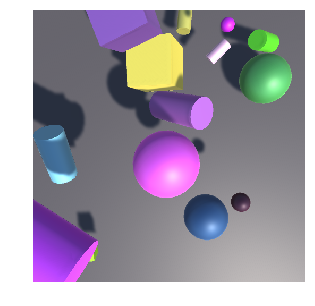

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [9]:
get_y_fn = lambda x: str(x).replace('img', 'layer')

In [10]:
open_image(get_y_fn(img_f), convert_mode='L').data.unique()

tensor([0.1137, 0.2039, 0.2980, 0.5529, 0.5843, 0.6471, 0.7922, 1.0000])

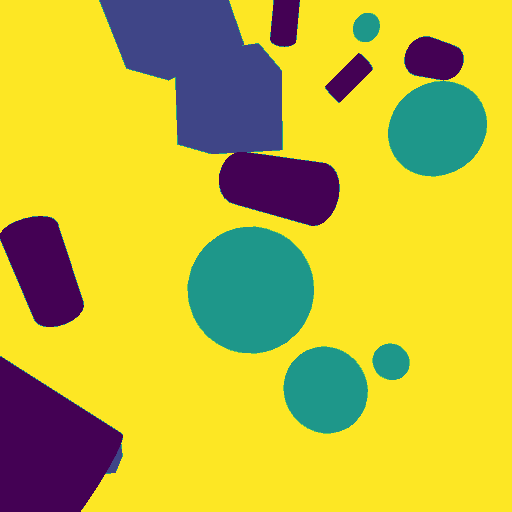

In [11]:
mask = open_mask(get_y_fn(img_f))
mask

In [12]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([512, 512]), tensor([[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [ 29,  29,  29,  ..., 255, 255, 255],
          [ 29,  29,  29,  ..., 255, 255, 255],
          [ 29,  29,  29,  ..., 255, 255, 255]]]))

In [13]:
codes = np.array(["0", "1", "2", "3", "4", "5", "6", "7", "Cube", "Sphere", "Sphere"])

# Data

In [14]:
size = src_size // 2
bs = 8

In [15]:
def just_image(x):
    return 'img' in str(x)

src = (SegmentationItemList.from_folder(path)
           .filter_by_func(just_image)
           .split_by_folder(train='train', valid='val')
           .label_from_func(get_y_fn, classes=codes))
src

LabelLists;

Train: LabelList (199 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data\captures;

Valid: LabelList (100 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data\captures;

Test: None

In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

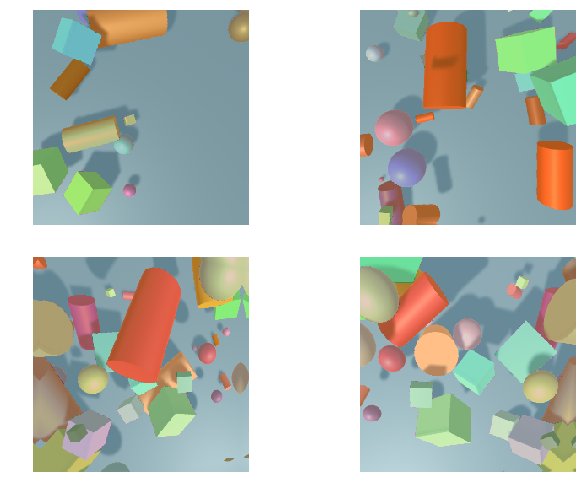

In [17]:
data.show_batch(2, figsize=(10, 7))

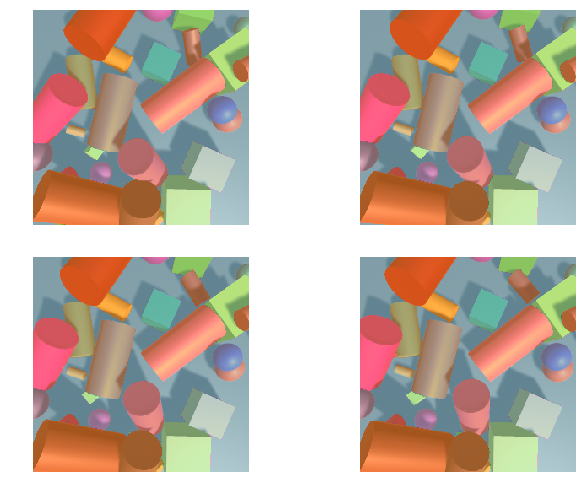

In [18]:
data.show_batch(2, figsize=(10, 7), ds_type=DatasetType.Valid)

# Model

In [19]:
name2id = {v: k for k, v in enumerate(codes)}
void_code = name2id['0']

def acc_segmentation(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [20]:
metrics = acc_segmentation

In [21]:
wd = 1e-2

In [22]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [23]:
lr_find(learn)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 4.92 GiB (GPU 0; 8.00 GiB total capacity; 1.30 GiB already allocated; 4.94 GiB free; 31.30 MiB cached)

In [ ]:
lr = 1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1')

In [ ]:
learn.show_results(rows=3, figsize=(16, 16))

In [ ]:
img = open_image((path / 'val').ls()[0])
display(img)
plt.imshow(learn.predict(img)[1].squeeze())